In [ ]:
%%!
kaggle datasets download -d tongpython/cat-and-dog
unzip cat-and-dog.zip -d content

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
train_data_dir = "training_set/training_set"
test_data_dir = "test_set/test_set"


class CatsDogsDataset(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)


# get and modify vgg pretrained model
def get_model():
    model = models.vgg16(weights=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer


def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()


@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


def get_data(train_data_dir, test_data_dir):
    train = CatsDogsDataset(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogsDataset(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [6]:
def main():
    train_data_dir = "./content/training_set/training_set"
    test_data_dir = "./content/test_set/test_set"

    trn_dl, val_dl = get_data(train_data_dir, test_data_dir)
    model, loss_fn, optimizer = get_model()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(5):
        print(f"epoch: {epoch+1}")

        train_epoch_losses, train_epoch_accuracies = [], []
        val_epoch_accuracies = []
        val_epoch_losses = []

        # Training
        model.train()
        num_batch = len(trn_dl)
        for ix, batch in enumerate(trn_dl, 1):
            print(f"\ttraining: {ix}/{num_batch}")
            x, y = batch

            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)

            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        # Validation
        model.eval()
        for ix, batch in enumerate(val_dl, 1):
            print(f"\tevaluating: {ix}/{num_batch}")

            x, y = batch
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

            validation_loss = val_loss(x, y, model, loss_fn)
            val_epoch_losses.append(validation_loss)

        train_epoch_loss = np.mean(train_epoch_losses)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)
        val_epoch_loss = np.mean(val_epoch_losses)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(
            f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}"
        )
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")

    return train_accuracies, val_accuracies

In [7]:
train_accuracies, val_accuracies = main()

/home/xujialiu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xujialiu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1
	training: 1/31
	training: 2/31
	training: 3/31
	training: 4/31
	training: 5/31
	training: 6/31
	training: 7/31
	training: 8/31
	training: 9/31
	training: 10/31
	training: 11/31
	training: 12/31
	training: 13/31
	training: 14/31
	training: 15/31
	training: 16/31
	training: 17/31
	training: 18/31
	training: 19/31
	training: 20/31
	training: 21/31
	training: 22/31
	training: 23/31
	training: 24/31
	training: 25/31
	training: 26/31
	training: 27/31
	training: 28/31
	training: 29/31
	training: 30/31
	training: 31/31
	evaluating: 1/31
	evaluating: 2/31
	evaluating: 3/31
	evaluating: 4/31
	evaluating: 5/31
	evaluating: 6/31
	evaluating: 7/31
	evaluating: 8/31
	evaluating: 9/31
	evaluating: 10/31
	evaluating: 11/31
	evaluating: 12/31
	evaluating: 13/31
	evaluating: 14/31
	evaluating: 15/31
	evaluating: 16/31
	evaluating: 17/31
	evaluating: 18/31
	evaluating: 19/31
	evaluating: 20/31
	evaluating: 21/31
	evaluating: 22/31
	evaluating: 23/31
	evaluating: 24/31
	evaluating: 25/31
	evalua

/tmp/ipykernel_146107/2729363627.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


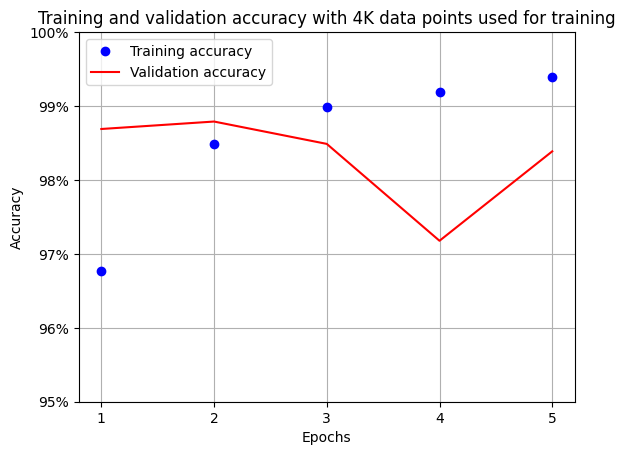

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()